# Step 1. Data Import
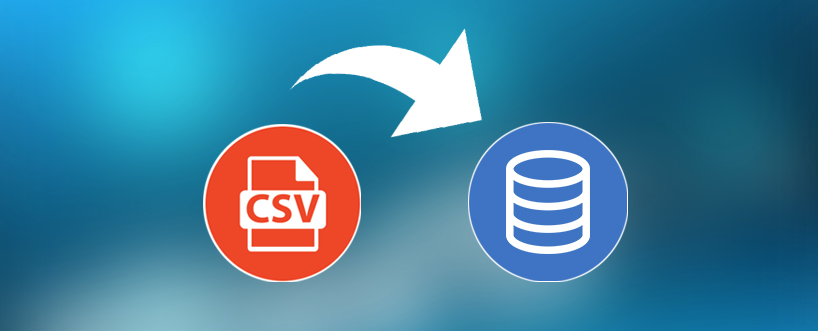

## TODO:
- check Kaggle competition page dedicated to leaks for updates


## Import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 150)
from colorama import Fore

from utility import optimize_columns_types, plot_timeseries

## Read data from csv
Use predefined types:

In [2]:
use_float16 = False
if use_float16:
    dtype = np.float16
else:
    dtype = np.float32
dtypes = {
    'building_id': np.uint16,
    'site_id': np.uint8,
    'meter': np.uint8,
    'meter_reading': np.float64,
    'row_id' : np.float64,
    'primary_use': 'category',
    'square_feet': np.float32,
    'year_built': dtype,
    'floor_count': dtype,
    'air_temperature': dtype,
    'cloud_coverage': dtype,
    'dew_temperature': dtype,
    'precip_depth_1_hr': dtype,  
    'sea_level_pressure': dtype,
    'wind_direction': dtype,   
    'wind_speed': dtype,
}
path_data = './data/'
train_df = pd.read_csv(path_data + 'train.csv', parse_dates=['timestamp'], dtype=dtypes)  
    # 1449 buildings x 4 meters x 366 days of 2016 x 24 hours - missing data
test_df = pd.read_csv(path_data + 'test.csv', parse_dates=['timestamp'], dtype=dtypes)  
    # 1449 buildings x 4 meters x 730 days of 2017-2018 x 24 hours - missing data
sample_submission_df = pd.read_csv(path_data + 'sample_submission.csv', dtype=dtypes)  
    # compact test_df
weather_train_df = pd.read_csv(path_data + 'weather_train.csv', parse_dates=['timestamp'], dtype=dtypes)  
    # 16 sites x 366 days of 2016 x 24 hours - missing data
weather_test_df = pd.read_csv(path_data + 'weather_test.csv', parse_dates=['timestamp'], dtype=dtypes)  
    # 16 sites x 730 days of 2017-2018 x 24 hours - missing data
building_metadata_df = pd.read_csv(path_data + 'building_metadata.csv', dtype=dtypes)  
    # 1449 buildings

## Merge data sources
Concat 2016 and 2017-2018 parts of data:

In [3]:
weather_df = pd.concat([weather_train_df, weather_test_df], ignore_index=True)
weather_df.sort_values(by=['site_id', 'timestamp'], inplace=True)
meters_readings_df = pd.concat([train_df, test_df], sort=False, ignore_index=True)
meters_readings_df.sort_values(by=['meter', 'building_id', 'timestamp'], inplace=True)

Adjust weather timestamp (weather is tracked in GMT, readings are tracked in local standard time):

In [4]:
site_GMT_offsets = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]
GMT_offset_map = {site: pd.Timedelta(f'{offset} h') for site, offset in enumerate(site_GMT_offsets)}
weather_df['timestamp'] = weather_df['timestamp'] + weather_df['site_id'].map(GMT_offset_map)

Prepare "skeleton" for merging tables:

In [5]:
rows = meters_readings_df[['meter', 'building_id']].drop_duplicates()
meters_timestamps = meters_readings_df.timestamp.unique()
timestamps = pd.DataFrame({'timestamp': 
    pd.date_range(meters_timestamps.min(), meters_timestamps.max(), freq='1h')})
rows['key'] = 0
timestamps['key'] = 0
datamart = rows.merge(timestamps, how='left', on='key')
datamart.drop('key', axis=1, inplace=True)

Merge datasources with "skeleton":

In [6]:
%%time
datamart = datamart.merge(meters_readings_df, how='left')
datamart = datamart.merge(building_metadata_df, on='building_id', how='left')
datamart = datamart.merge(weather_df, on=['site_id', 'timestamp'], how='left')
datamart.sort_values(by=['meter', 'building_id', 'timestamp'], inplace=True)
datamart.rename(columns={'meter_reading': 'fact'}, inplace=True)

Wall time: 1min 36s


## Load leaks data
Download file from https://www.kaggle.com/yamsam/ashrae-leak-data-station/output

In [7]:
leak_df = pd.read_feather(path_data + 'leak.feather')
leak_df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800319 entries, 0 to 16800318
Data columns (total 4 columns):
building_id      16800319 non-null int64
meter            16800319 non-null float64
meter_reading    16800319 non-null float64
timestamp        16800319 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 512.7 MB


In [8]:
leak_df['meter'] = leak_df['meter'].astype(np.uint8)
leak_df['building_id'] = leak_df['building_id'].astype(np.uint16)
leak_df['leak'] = leak_df['meter_reading'].astype(np.float64)
leak_df = leak_df[['meter', 'building_id', 'timestamp', 'leak']]
leak_df = leak_df.sort_values(by=['meter', 'building_id', 'timestamp']).reset_index(drop=True)
leak_df.info(memory_usage='deep', null_counts=True)
leak_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800319 entries, 0 to 16800318
Data columns (total 4 columns):
meter          16800319 non-null uint8
building_id    16800319 non-null uint16
timestamp      16800319 non-null datetime64[ns]
leak           16800319 non-null float64
dtypes: datetime64[ns](1), float64(1), uint16(1), uint8(1)
memory usage: 304.4 MB


,meter,building_id,timestamp,leak
0,0,0,2016-01-01 00:00:00,0.0
1,0,0,2016-01-01 01:00:00,0.0
2,0,0,2016-01-01 02:00:00,0.0
3,0,0,2016-01-01 03:00:00,0.0
4,0,0,2016-01-01 04:00:00,0.0
...,...,...,...,...
16800314,3,287,2018-12-31 19:00:00,0.0
16800315,3,287,2018-12-31 20:00:00,0.0
16800316,3,287,2018-12-31 21:00:00,0.0
16800317,3,287,2018-12-31 22:00:00,0.0


Drop dublicates in leak dataframe:

In [9]:
leak_df.drop_duplicates(subset=['meter', 'building_id', 'timestamp'], inplace=True)
leak_df.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16800125 entries, 0 to 16800318
Data columns (total 4 columns):
meter          16800125 non-null uint8
building_id    16800125 non-null uint16
timestamp      16800125 non-null datetime64[ns]
leak           16800125 non-null float64
dtypes: datetime64[ns](1), float64(1), uint16(1), uint8(1)
memory usage: 432.6 MB


Merge leaks with datamart:

In [10]:
datamart = datamart.merge(leak_df, on=['meter', 'building_id', 'timestamp'], how='left')
datamart.sort_values(by=['meter', 'building_id', 'timestamp'], inplace=True)
datamart.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62603520 entries, 0 to 62603519
Data columns (total 18 columns):
meter                 62603520 non-null uint8
building_id           62603520 non-null uint16
timestamp             62603520 non-null datetime64[ns]
fact                  20216100 non-null float64
row_id                41697600 non-null float64
site_id               62603520 non-null uint8
primary_use           62603520 non-null category
square_feet           62603520 non-null float32
year_built            25672704 non-null float32
floor_count           10889856 non-null float32
air_temperature       62261805 non-null float32
cloud_coverage        33861221 non-null float32
dew_temperature       62219377 non-null float32
precip_depth_1_hr     50749566 non-null float32
sea_level_pressure    58819365 non-null float32
wind_direction        58130731 non-null float32
wind_speed            62133224 non-null float32
leak                  16800125 non-null float64
dtypes: category(1

Check for duplicates:

In [11]:
assert datamart[['meter', 'building_id', 'timestamp']].duplicated().sum() == 0, 'Duplicates found!'

## Save results
Export to feather:

In [12]:
datamart.to_feather('./datasets/datamart.feather')

## Notes